# Vector Database Practical Demonstration

This notebook demonstrates practical use cases for vector databases: Milvus, Weaviate, and Qdrant. 
We'll explore:

1. **Setup and Connection**: How to connect to each database
2. **Schema Definition**: How to define schemas for each platform
3. **Data Management**: How to insert, update, and delete data
4. **Vector Search**: Perform similarity searches and filter results
5. **Practical Applications**: Text search and image search examples

**Prerequisites:**
- Vector databases are running (via the `all_databases_docker_compose.yml` file)
- Required Python packages are installed

In [1]:
# 1. Install Required Packages
!pip install pymilvus==2.2.3 weaviate-client==4.4.2 qdrant-client==1.4.0 sentence-transformers==2.3.0 numpy pandas matplotlib plotly pillow scikit-learn

  Using cached pymilvus-2.2.3-py3-none-any.whl.metadata (4.1 kB)


ERROR: Ignored the following yanked versions: 1.14.0
ERROR: Could not find a version that satisfies the requirement qdrant-client==1.4.0 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.1.3, 0.1.4, 0.1.5, 0.2.0, 0.3.0, 0.3.1, 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 0.3.8, 0.3.9, 0.3.10, 0.3.11, 0.3.12, 0.4.1, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.3, 0.8.4, 0.8.5, 0.8.6, 0.8.7, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.7, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.11.0, 0.11.1, 0.11.3, 0.11.4, 0.11.5, 0.11.6, 0.11.7, 0.11.8, 0.11.9, 1.7.1, 1.7.2, 1.7.3, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.10.0, 1.10.1, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.12.2, 1.13.0, 1.13.1, 1.13.2, 1.13.3, 1.14.1, 1.14.2)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for qdrant-client==1.4.0


## 1. Setup and Connection

First, let's set up connections to all three vector databases.

In [2]:
# Import common libraries
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import uuid
import json

# Set common parameters
VECTOR_DIMENSION = 384  # Using sentence-transformers with all-MiniLM-L6-v2 (384 dimensions)
SAMPLE_DATA_SIZE = 1000  # Number of sample data points to generate

# Generate some sample data for our tests
from sentence_transformers import SentenceTransformer

# Load a pre-trained model
print("Loading sentence transformer model...")
model = SentenceTransformer('all-MiniLM-L6-v2')

Loading sentence transformer model...


In [3]:
# Create sample data of movie descriptions with corresponding embeddings
import random

# Sample movie genres
genres = ["Action", "Adventure", "Comedy", "Drama", "Horror", "Romance", "Sci-Fi", "Thriller"]

# Sample movie titles and descriptions
movies = [
    {"title": "The Last Adventure", "description": "An epic journey through uncharted territories."},
    {"title": "Midnight Chase", "description": "A detective hunts a criminal through the dark streets of the city."},
    {"title": "Love in Paris", "description": "Two strangers meet in the city of love and their lives change forever."},
    {"title": "Galactic Voyager", "description": "Astronauts discover a new form of life on a distant planet."},
    {"title": "The Funniest Day", "description": "A series of hilarious events unfold during a family reunion."},
    {"title": "Haunted Manor", "description": "A family moves into a house with a dark and terrifying secret."},
    {"title": "Corporate Clash", "description": "Rival business executives compete for a major contract."},
    {"title": "Time Warp", "description": "A scientist invents a time machine with unexpected consequences."},
    {"title": "Mountain Rescue", "description": "A team of rescuers battle extreme weather to save stranded hikers."},
    {"title": "Digital Dreams", "description": "A programmer creates an AI that becomes too intelligent."}
]

def generate_movie_data(num_samples):
    """Generate random movie data with titles, descriptions, and metadata"""
    data = []
    
    for i in range(num_samples):
        # Select a base movie and modify slightly to create variations
        base_movie = random.choice(movies)
        
        # Create variations with a bit of randomness
        movie_year = random.randint(1980, 2025)
        selected_genres = random.sample(genres, k=random.randint(1, 3))
        rating = round(random.uniform(1.0, 10.0), 1)
        
        # Create a slightly modified title and description
        if random.random() > 0.7:  # 30% chance of using the original
            title = f"{base_movie['title']} {roman_numeral(random.randint(1, 5))}"
            description = f"{base_movie['description']} Set in {movie_year}."
        else:
            title = base_movie['title']
            description = base_movie['description']
            
        # Construct the movie document
        movie_doc = {
            "id": i,
            "title": title,
            "description": description,
            "full_text": f"{title}: {description}",
            "year": movie_year,
            "genres": selected_genres,
            "rating": rating
        }
        
        data.append(movie_doc)
    
    return data

def roman_numeral(num):
    """Convert integer to Roman numeral for movie sequel numbering"""
    roman_numerals = {1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V'}
    return roman_numerals.get(num, str(num))

# Generate movie data
print(f"Generating {SAMPLE_DATA_SIZE} sample movie entries...")
movie_data = generate_movie_data(SAMPLE_DATA_SIZE)

# Generate embeddings for each movie description
print("Creating embeddings for movie descriptions...")
for movie in tqdm(movie_data):
    # Create embeddings for the full text (title + description)
    embedding = model.encode(movie["full_text"])
    movie["vector"] = embedding

print(f"Created {len(movie_data)} movie entries with {VECTOR_DIMENSION}-dimensional vectors")

# Display a few samples
pd.DataFrame(movie_data[:5])[['id', 'title', 'description', 'year', 'genres', 'rating']]

Generating 1000 sample movie entries...
Creating embeddings for movie descriptions...


  0%|          | 0/1000 [00:00<?, ?it/s]

Created 1000 movie entries with 384-dimensional vectors


id                 title  \
0   0       Corporate Clash   
1   1        Midnight Chase   
2   2       Corporate Clash   
3   3      Galactic Voyager   
4   4  The Funniest Day III   

                                         description  year  \
0  Rival business executives compete for a major ...  2025   
1  A detective hunts a criminal through the dark ...  2004   
2  Rival business executives compete for a major ...  1986   
3  Astronauts discover a new form of life on a di...  1989   
4  A series of hilarious events unfold during a f...  2025   

                       genres  rating  
0  [Drama, Romance, Thriller]     5.8  
1          [Horror, Thriller]     3.5  
2     [Action, Comedy, Drama]     1.3  
3  [Drama, Action, Adventure]     6.4  
4    [Horror, Drama, Romance]     4.5

## 2. Milvus Implementation

In [4]:
# Milvus Implementation
from pymilvus import connections, utility, Collection, CollectionSchema, FieldSchema
from pymilvus import DataType as MilvusDataType

# Milvus connection parameters
MILVUS_HOST = "localhost"
MILVUS_PORT = "19530"
MILVUS_COLLECTION_NAME = "movie_demo_collection"

# Connect to Milvus
try:
    connections.connect(host=MILVUS_HOST, port=MILVUS_PORT)
    print(f"Successfully connected to Milvus at {MILVUS_HOST}:{MILVUS_PORT}")
except Exception as e:
    print(f"Failed to connect to Milvus: {e}")
    print("Please ensure the Milvus service is running.")
    raise e

# Drop collection if it already exists
if utility.has_collection(MILVUS_COLLECTION_NAME):
    utility.drop_collection(MILVUS_COLLECTION_NAME)
    print(f"Dropped existing Milvus collection: {MILVUS_COLLECTION_NAME}")

# Define collection schema
fields = [
    FieldSchema(name="id", dtype=MilvusDataType.INT64, is_primary=True, auto_id=False),
    FieldSchema(name="title", dtype=MilvusDataType.VARCHAR, max_length=100),
    FieldSchema(name="description", dtype=MilvusDataType.VARCHAR, max_length=500),
    FieldSchema(name="year", dtype=MilvusDataType.INT32),
    # Store genres as a JSON string
    FieldSchema(name="genres", dtype=MilvusDataType.VARCHAR, max_length=200),
    FieldSchema(name="rating", dtype=MilvusDataType.FLOAT),
    FieldSchema(name="vector", dtype=MilvusDataType.FLOAT_VECTOR, dim=VECTOR_DIMENSION)
]

schema = CollectionSchema(fields, description="Movie collection for vector search demo")
collection = Collection(MILVUS_COLLECTION_NAME, schema=schema)
print(f"Created Milvus collection: {MILVUS_COLLECTION_NAME}")

# Create an index on the vector field for similarity search
index_params = {
    "metric_type": "COSINE",
    "index_type": "HNSW",
    "params": {
        "M": 16,
        "efConstruction": 200
    }
}
collection.create_index(field_name="vector", index_params=index_params)
print("Created HNSW index on vector field")

# Prepare data for insertion
ids = [movie["id"] for movie in movie_data]
titles = [movie["title"] for movie in movie_data]
descriptions = [movie["description"] for movie in movie_data]
years = [movie["year"] for movie in movie_data]
# Convert genres list to JSON string for Milvus
genres = [json.dumps(movie["genres"]) for movie in movie_data]
ratings = [movie["rating"] for movie in movie_data]
vectors = [movie["vector"].tolist() for movie in movie_data]

# Insert data into collection
entities = [ids, titles, descriptions, years, genres, ratings, vectors]
insert_result = collection.insert(entities)
collection.flush()
print(f"Inserted {len(ids)} records into Milvus collection")

# Load collection for search
collection.load()
print(f"Loaded collection {MILVUS_COLLECTION_NAME} for search")

Successfully connected to Milvus at localhost:19530
Dropped existing Milvus collection: movie_demo_collection
Created Milvus collection: movie_demo_collection
Created HNSW index on vector field
Inserted 1000 records into Milvus collection
Loaded collection movie_demo_collection for search


In [5]:
# Perform a vector search in Milvus
def milvus_search(query_text, top_k=5, year_filter=None):
    """
    Search for similar movies in Milvus
    
    Args:
        query_text: Text to search for
        top_k: Number of results to return
        year_filter: Optional filter for movie year (e.g., year > 2000)
    """
    # Encode the query text
    query_vector = model.encode(query_text)
    
    # Prepare expression for filtering (if needed)
    expr = None
    if year_filter:
        expr = year_filter
    
    # Search parameters
    search_params = {
        "metric_type": "COSINE",
        "params": {"ef": 100}
    }
    
    # Perform search
    results = collection.search(
        data=[query_vector], 
        anns_field="vector",
        param=search_params,
        limit=top_k,
        expr=expr,
        output_fields=["title", "description", "year", "genres", "rating"]
    )
    
    return results

# Example search queries
print("MILVUS SEARCH EXAMPLES:")
print("\nExample 1: Search for science fiction movies")
results = milvus_search("science fiction space adventure", top_k=3)

# Format and display results
for i, hits in enumerate(results):
    print(f"\nTop {len(hits)} results for query:")
    for hit in hits:
        genres_list = json.loads(hit.entity.get('genres'))
        print(f"ID: {hit.id}, Score: {hit.score:.4f}")
        print(f"Title: {hit.entity.get('title')}")
        print(f"Description: {hit.entity.get('description')}")
        print(f"Year: {hit.entity.get('year')}, Rating: {hit.entity.get('rating')}")
        print(f"Genres: {', '.join(genres_list)}")
        print("-" * 50)

# Example with year filter
print("\nExample 2: Recent comedy movies (after 2010)")
results = milvus_search("funny comedy laugh", top_k=3, year_filter="year > 2010")

# Format and display results
for i, hits in enumerate(results):
    print(f"\nTop {len(hits)} results for 'comedy' (after 2010):")
    for hit in hits:
        genres_list = json.loads(hit.entity.get('genres'))
        print(f"ID: {hit.id}, Score: {hit.score:.4f}")
        print(f"Title: {hit.entity.get('title')}")
        print(f"Description: {hit.entity.get('description')}")
        print(f"Year: {hit.entity.get('year')}, Rating: {hit.entity.get('rating')}")
        print(f"Genres: {', '.join(genres_list)}")
        print("-" * 50)

MILVUS SEARCH EXAMPLES:

Example 1: Search for science fiction movies

Top 3 results for query:
ID: 74, Score: 0.5775
Title: The Last Adventure V
Description: An epic journey through uncharted territories. Set in 2022.
Year: 2022, Rating: 3.5
Genres: Adventure
--------------------------------------------------
ID: 578, Score: 0.5741
Title: The Last Adventure II
Description: An epic journey through uncharted territories. Set in 2005.
Year: 2005, Rating: 7.400000095367432
Genres: Adventure, Drama, Action
--------------------------------------------------
ID: 92, Score: 0.5741
Title: The Last Adventure II
Description: An epic journey through uncharted territories. Set in 2005.
Year: 2005, Rating: 7.0
Genres: Adventure, Horror
--------------------------------------------------

Example 2: Recent comedy movies (after 2010)

Top 3 results for 'comedy' (after 2010):
ID: 120, Score: 0.5480
Title: The Funniest Day
Description: A series of hilarious events unfold during a family reunion.
Year: 2

## 3. Weaviate Implementation

In [ ]:
# Weaviate Implementation
import weaviate
from weaviate import Client
from weaviate.classes.config import Configure, Property, VectorDistances
from weaviate.classes.config import DataType as WeaviateDataType
from weaviate.classes.query import Filter as WeaviateFilter

# Weaviate connection parameters
WEAVIATE_URL = "http://localhost:8080"
WEAVIATE_CLASS_NAME = "Movie"

# Connect to Weaviate
try:
    client = weaviate.connect_to_local()
    print(f"Successfully connected to Weaviate at {WEAVIATE_URL}")
except Exception as e:
    print(f"Failed to connect to Weaviate: {e}")
    print("Please ensure the Weaviate service is running.")
    raise e

# Check if class exists and delete it if it does
try:
    if client.collections.exists(WEAVIATE_CLASS_NAME):
        client.collections.delete(WEAVIATE_CLASS_NAME)
        print(f"Dropped existing Weaviate class: {WEAVIATE_CLASS_NAME}")
except Exception as e:
    print(f"Warning: {e}")

# Create schema
try:
    movie_collection = client.collections.create(
        name=WEAVIATE_CLASS_NAME,
        description="Movie collection for vector search demo",
        properties=[
            Property(name="title", data_type=WeaviateDataType.TEXT, description="Movie title"),
            Property(name="description", data_type=WeaviateDataType.TEXT, description="Movie description"),
            Property(name="year", data_type=WeaviateDataType.INT, description="Release year"),
            Property(name="genres", data_type=WeaviateDataType.TEXT_ARRAY, description="Movie genres"),
            Property(name="rating", data_type=WeaviateDataType.NUMBER, description="Movie rating")
        ],
        # Configure vector index settings
        vector_index_config=Configure.VectorIndex.hnsw(
            ef_construction=128,
            distance_metric=VectorDistances.COSINE
        ),
    )
    print(f"Created Weaviate class: {WEAVIATE_CLASS_NAME}")
except Exception as e:
    print(f"Error creating Weaviate schema: {e}")
    raise e

# Batch import data into Weaviate
def batch_import_to_weaviate(client, movies, batch_size=100):
    """Import movies data to Weaviate in batches"""
    collection = client.collections.get(WEAVIATE_CLASS_NAME)
    
    with collection.batch.dynamic() as batch:
        batch.batch_size = batch_size
        for movie in tqdm(movies):
            # Add movie to batch
            batch.add_object(
                properties={
                    "title": movie["title"],
                    "description": movie["description"],
                    "year": movie["year"],
                    "genres": movie["genres"],
                    "rating": movie["rating"]
                },
                vector=movie["vector"]
            )
    
    return len(movies)

# Insert data into Weaviate
print(f"Importing {len(movie_data)} movies into Weaviate...")
num_imported = batch_import_to_weaviate(client, movie_data)
print(f"Successfully imported {num_imported} movies into Weaviate")

c:\Users\hokha\AppData\Local\Programs\Python\Python313\Lib\site-packages\weaviate\warnings.py:130: DeprecationWarning: Dep005: You are using weaviate-client version 4.4.2. The latest version is 4.14.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


Successfully connected to Weaviate at http://localhost:8080
Dropped existing Weaviate class: Movie
Created Weaviate class: Movie
Importing 1000 movies into Weaviate...


  0%|          | 0/1000 [00:00<?, ?it/s]

Successfully imported 1000 movies into Weaviate


In [ ]:
# Perform vector search in Weaviate
def weaviate_search(query_text, top_k=5, filter_expr=None):
    """
    Search for similar movies in Weaviate
    
    Args:
        query_text: Text to search for
        top_k: Number of results to return
        filter_expr: Optional filter expression
    """
    # Get the collection
    collection = client.collections.get(WEAVIATE_CLASS_NAME)
    
    # Encode the query text
    query_vector = model.encode(query_text).tolist()
    
    # In Weaviate v4.4.2, we need to use the filter directly in the near_vector method
    # or use the query builder pattern differently
    if filter_expr:
        # Use the where filter parameter in the query
        results = collection.query.near_vector(
            near_vector=query_vector,
            limit=top_k,
            return_properties=["title", "description", "year", "genres", "rating"],
            filters=filter_expr  # Using where_filter parameter instead of where
        ).objects
    else:
        # Without filter
        results = collection.query.near_vector(
            near_vector=query_vector,
            limit=top_k,
            return_properties=["title", "description", "year", "genres", "rating"]
        ).objects
    
    return results

# Example searches
print("WEAVIATE SEARCH EXAMPLES:")
print("\nExample 1: Search for horror movies")
horror_results = weaviate_search("scary horror haunted ghost", top_k=3)

# Display results
print(f"\nTop {len(horror_results)} horror movie results:")
for i, result in enumerate(horror_results):
    props = result.properties
    # print(f"Rank {i+1}, Score: {result.metadata.certainty:.4f}")
    print(f"Title: {props['title']}")
    print(f"Description: {props['description']}")
    print(f"Year: {props['year']}, Rating: {props['rating']}")
    print(f"Genres: {', '.join(props['genres'])}")
    print("-" * 50)

# Example with filter
print("\nExample 2: Top-rated romance movies (rating > 7.0)")

romance_filter = WeaviateFilter.by_property("rating").greater_than(7.0)
romance_results = weaviate_search("love romance relationship", top_k=3, filter_expr=romance_filter)

# Display results
print(f"\nTop {len(romance_results)} romance movie results (rating > 7.0):")
for i, result in enumerate(romance_results):
    props = result.properties
    # print(f"Rank {i+1}, Score: {result.metadata.certainty:.4f}")
    print(f"Title: {props['title']}")
    print(f"Description: {props['description']}")
    print(f"Year: {props['year']}, Rating: {props['rating']}")
    print(f"Genres: {', '.join(props['genres'])}")
    print("-" * 50)

WEAVIATE SEARCH EXAMPLES:

Example 1: Search for horror movies

Top 3 horror movie results:
Title: Haunted Manor
Description: A family moves into a house with a dark and terrifying secret.
Year: 2008, Rating: 9.5
Genres: Comedy, Romance
--------------------------------------------------
Title: Haunted Manor
Description: A family moves into a house with a dark and terrifying secret.
Year: 2007, Rating: 2.5
Genres: Action
--------------------------------------------------
Title: Haunted Manor
Description: A family moves into a house with a dark and terrifying secret.
Year: 2025, Rating: 5.7
Genres: Drama, Action
--------------------------------------------------

Example 2: Top-rated romance movies (rating > 7.0)

Top 3 romance movie results (rating > 7.0):
Title: Love in Paris
Description: Two strangers meet in the city of love and their lives change forever.
Year: 2007, Rating: 7.6
Genres: Thriller, Comedy
--------------------------------------------------
Title: Love in Paris
Descript

## 4. Qdrant Implementation

In [12]:
# Qdrant Implementation
from qdrant_client import QdrantClient
from qdrant_client.http import models as rest
from qdrant_client.http.models import Distance, VectorParams, PointStruct, Filter

# Qdrant connection parameters
QDRANT_HOST = "localhost"
QDRANT_PORT = 6333
QDRANT_COLLECTION_NAME = "movies_demo"

# Connect to Qdrant
try:
    qdrant_client = QdrantClient(host=QDRANT_HOST, port=QDRANT_PORT)
    print(f"Successfully connected to Qdrant at {QDRANT_HOST}:{QDRANT_PORT}")
except Exception as e:
    print(f"Failed to connect to Qdrant: {e}")
    print("Please ensure the Qdrant service is running.")
    raise e

# Drop collection if it exists
try:
    if qdrant_client.collection_exists(QDRANT_COLLECTION_NAME):
        qdrant_client.delete_collection(collection_name=QDRANT_COLLECTION_NAME)
        print(f"Dropped existing Qdrant collection: {QDRANT_COLLECTION_NAME}")
except Exception as e:
    print(f"Error checking/deleting collection: {e}")

# Create collection
try:
    qdrant_client.create_collection(
        collection_name=QDRANT_COLLECTION_NAME,
        vectors_config=rest.VectorParams(
            size=VECTOR_DIMENSION,
            distance=rest.Distance.COSINE
        ),
        # Configure HNSW parameters for better performance
        hnsw_config=rest.HnswConfigDiff(
            m=16,
            ef_construct=200
        )
    )
    print(f"Created Qdrant collection: {QDRANT_COLLECTION_NAME}")
except Exception as e:
    print(f"Error creating Qdrant collection: {e}")
    raise e

# Batch import function for Qdrant
def batch_import_to_qdrant(client, movies, batch_size=100):
    """Import movies data to Qdrant in batches"""
    total = 0
    for i in range(0, len(movies), batch_size):
        batch = movies[i:i+batch_size]
        points = []
        
        for movie in batch:
            # Create a point with id, vector, and payload
            point = rest.PointStruct(
                id=movie["id"],
                vector=movie["vector"].tolist(),
                payload={
                    "title": movie["title"],
                    "description": movie["description"],
                    "year": movie["year"],
                    "genres": movie["genres"],
                    "rating": movie["rating"]
                }
            )
            points.append(point)
        
        # Insert batch
        client.upsert(
            collection_name=QDRANT_COLLECTION_NAME,
            points=points,
            wait=True if i + batch_size >= len(movies) else False  # Wait only on the last batch
        )
        total += len(points)
        
    return total

# Insert data into Qdrant
print(f"Importing {len(movie_data)} movies into Qdrant...")
num_imported = batch_import_to_qdrant(qdrant_client, movie_data)
print(f"Successfully imported {num_imported} movies into Qdrant")

Successfully connected to Qdrant at localhost:6333
Dropped existing Qdrant collection: movies_demo
Created Qdrant collection: movies_demo
Importing 1000 movies into Qdrant...
Successfully imported 1000 movies into Qdrant


In [13]:
# Perform vector search in Qdrant
def qdrant_search(query_text, top_k=5, filter_condition=None):
    """
    Search for similar movies in Qdrant
    
    Args:
        query_text: Text to search for
        top_k: Number of results to return
        filter_condition: Optional filter condition
    """
    # Encode the query text
    query_vector = model.encode(query_text)
    
    # Perform search
    search_result = qdrant_client.search(
        collection_name=QDRANT_COLLECTION_NAME,
        query_vector=query_vector.tolist(),
        limit=top_k,
        query_filter=filter_condition
    )
    
    return search_result

# Example searches
print("QDRANT SEARCH EXAMPLES:")
print("\nExample 1: Search for action movies")
action_results = qdrant_search("action adventure explosion chase", top_k=3)

# Display results
print(f"\nTop {len(action_results)} action movie results:")
for i, result in enumerate(action_results):
    print(f"Rank {i+1}, Score: {result.score:.4f}")
    print(f"Title: {result.payload['title']}")
    print(f"Description: {result.payload['description']}")
    print(f"Year: {result.payload['year']}, Rating: {result.payload['rating']}")
    print(f"Genres: {', '.join(result.payload['genres'])}")
    print("-" * 50)

# Example with filter
print("\nExample 2: Thriller movies from the 2000s")
year_filter = rest.Filter(
    must=[
        rest.FieldCondition(
            key="year",
            range=rest.Range(
                gte=2000,
                lt=2010
            )
        )
    ]
)
thriller_results = qdrant_search("thriller suspense mystery detective", top_k=3, filter_condition=year_filter)

# Display results
print(f"\nTop {len(thriller_results)} thriller movie results from the 2000s:")
for i, result in enumerate(thriller_results):
    print(f"Rank {i+1}, Score: {result.score:.4f}")
    print(f"Title: {result.payload['title']}")
    print(f"Description: {result.payload['description']}")
    print(f"Year: {result.payload['year']}, Rating: {result.payload['rating']}")
    print(f"Genres: {', '.join(result.payload['genres'])}")
    print("-" * 50)

QDRANT SEARCH EXAMPLES:

Example 1: Search for action movies

Top 3 action movie results:
Rank 1, Score: 0.4670
Title: The Last Adventure V
Description: An epic journey through uncharted territories. Set in 1996.
Year: 1996, Rating: 4.4
Genres: Action
--------------------------------------------------
Rank 2, Score: 0.4641
Title: The Last Adventure V
Description: An epic journey through uncharted territories. Set in 2011.
Year: 2011, Rating: 1.5
Genres: Adventure
--------------------------------------------------
Rank 3, Score: 0.4598
Title: The Last Adventure V
Description: An epic journey through uncharted territories. Set in 2018.
Year: 2018, Rating: 1.5
Genres: Drama, Sci-Fi, Thriller
--------------------------------------------------

Example 2: Thriller movies from the 2000s

Top 3 thriller movie results from the 2000s:
Rank 1, Score: 0.6536
Title: Midnight Chase
Description: A detective hunts a criminal through the dark streets of the city.
Year: 2004, Rating: 3.5
Genres: Horror

C:\Users\hokha\AppData\Local\Temp\ipykernel_14436\1355381846.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = qdrant_client.search(


## 5. Comparative Analysis

Let's compare the performance and features of these vector databases for our movie search use case.

Testing Milvus performance...


  0%|          | 0/10 [00:00<?, ?it/s]

Testing Weaviate performance...


  0%|          | 0/10 [00:00<?, ?it/s]

Testing Qdrant performance...


  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\hokha\AppData\Local\Temp\ipykernel_14436\1355381846.py:15: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_result = qdrant_client.search(



Average Search Time by Database:
   Database  Time (seconds)
0    Milvus        0.013035
1    Qdrant        0.019014
2  Weaviate        0.010792


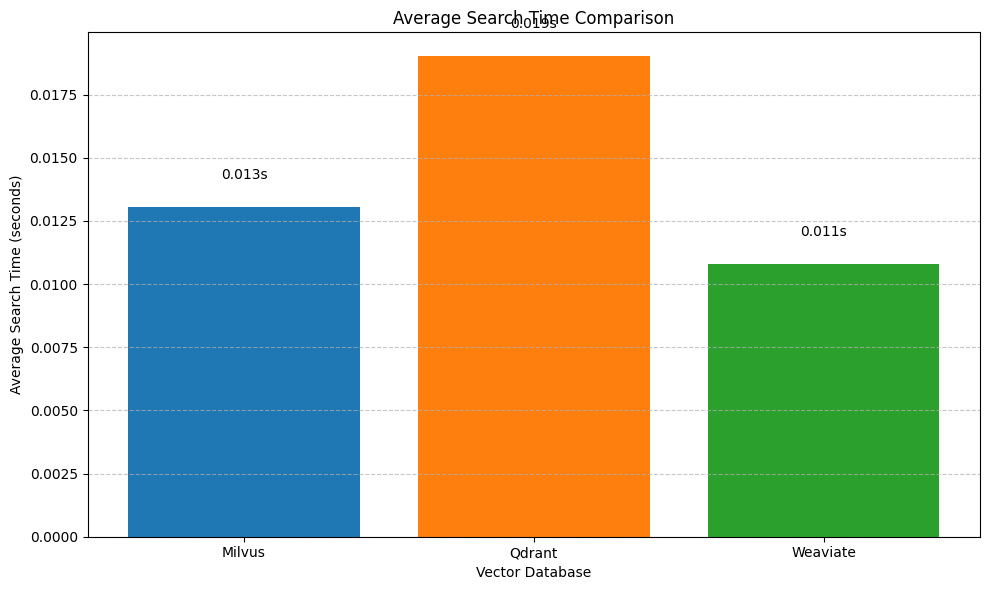

C:\Users\hokha\AppData\Local\Temp\ipykernel_14436\1617993199.py:123: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=perf_df['Database'].unique(), patch_artist=True,


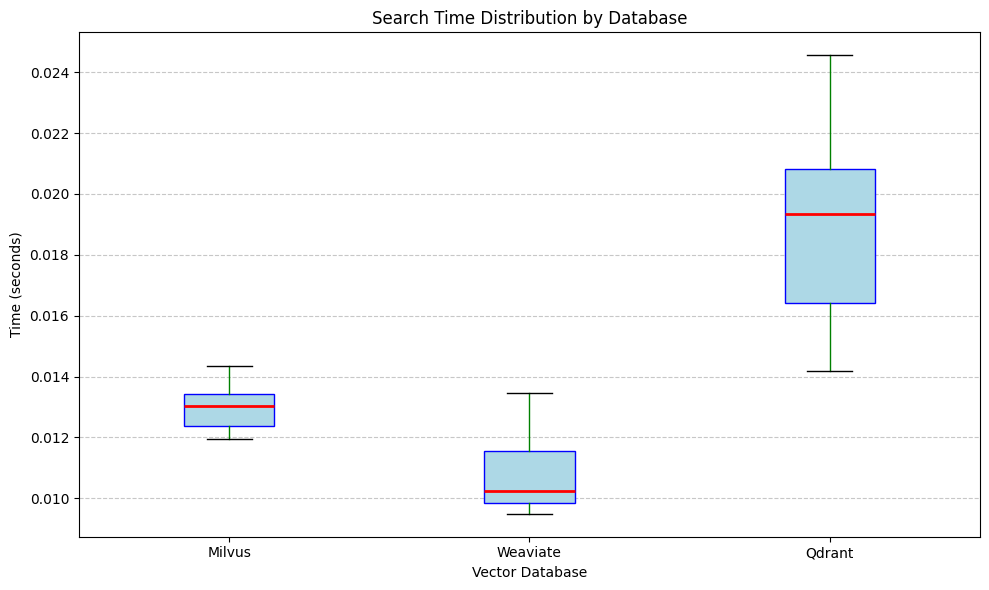

In [14]:
# Performance Comparison
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Generate a set of diverse query texts
query_texts = [
    "science fiction space adventure",
    "romantic comedy in Paris",
    "thrilling detective mystery",
    "horror ghost haunted house",
    "corporate drama business",
    "time travel paradox",
    "family comedy funny",
    "action adventure hero",
    "fantasy magical journey",
    "documentary real story"
]

# Parameters
TOP_K = 5
NUM_RUNS = 3  # Number of runs for averaging

# Results storage
performance_results = []

# Milvus performance test
print("Testing Milvus performance...")
for query in tqdm(query_texts):
    query_vector = model.encode(query)
    
    # Warm-up run
    milvus_search(query, top_k=TOP_K)
    
    # Timed runs
    milvus_times = []
    for _ in range(NUM_RUNS):
        start_time = time.time()
        milvus_search(query, top_k=TOP_K)
        query_time = time.time() - start_time
        milvus_times.append(query_time)
    
    avg_time = sum(milvus_times) / len(milvus_times)
    performance_results.append({
        "Database": "Milvus",
        "Query": query,
        "Time (seconds)": avg_time
    })

# Weaviate performance test
print("Testing Weaviate performance...")
for query in tqdm(query_texts):
    # Warm-up run
    weaviate_search(query, top_k=TOP_K)
    
    # Timed runs
    weaviate_times = []
    for _ in range(NUM_RUNS):
        start_time = time.time()
        weaviate_search(query, top_k=TOP_K)
        query_time = time.time() - start_time
        weaviate_times.append(query_time)
    
    avg_time = sum(weaviate_times) / len(weaviate_times)
    performance_results.append({
        "Database": "Weaviate",
        "Query": query,
        "Time (seconds)": avg_time
    })

# Qdrant performance test
print("Testing Qdrant performance...")
for query in tqdm(query_texts):
    # Warm-up run
    qdrant_search(query, top_k=TOP_K)
    
    # Timed runs
    qdrant_times = []
    for _ in range(NUM_RUNS):
        start_time = time.time()
        qdrant_search(query, top_k=TOP_K)
        query_time = time.time() - start_time
        qdrant_times.append(query_time)
    
    avg_time = sum(qdrant_times) / len(qdrant_times)
    performance_results.append({
        "Database": "Qdrant",
        "Query": query,
        "Time (seconds)": avg_time
    })

# Convert to dataframe
perf_df = pd.DataFrame(performance_results)

# Calculate average performance by database
avg_performance = perf_df.groupby("Database")["Time (seconds)"].mean().reset_index()
print("\nAverage Search Time by Database:")
print(avg_performance)

# Plot search times using Matplotlib (không cần Plotly hoặc nbformat)
plt.figure(figsize=(10, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
bars = plt.bar(avg_performance['Database'], avg_performance['Time (seconds)'], color=colors)

# Thêm giá trị lên mỗi thanh
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{height:.3f}s',
             ha='center', va='bottom', fontsize=10)

plt.title('Average Search Time Comparison')
plt.xlabel('Vector Database')
plt.ylabel('Average Search Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tạo boxplot để hiển thị phân phối thời gian truy vấn
plt.figure(figsize=(10, 6))
box_data = [perf_df[perf_df['Database'] == db]['Time (seconds)'] for db in perf_df['Database'].unique()]
plt.boxplot(box_data, labels=perf_df['Database'].unique(), patch_artist=True,
           boxprops=dict(facecolor='lightblue', color='blue'),
           whiskerprops=dict(color='green'),
           medianprops=dict(color='red', linewidth=2))

plt.title('Search Time Distribution by Database')
plt.xlabel('Vector Database')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 6. Weaviate CLIP Module cho Tìm kiếm Đa phương tiện (Multimodal Search)

Trong phần này, chúng ta sẽ triển khai và sử dụng module CLIP của Weaviate để thực hiện tìm kiếm đa phương tiện mạnh mẽ.

Weaviate CLIP (Contrastive Language-Image Pre-training) là một module chính thức cho phép:

1. Tìm kiếm hình ảnh bằng truy vấn văn bản (Text-to-Image)
2. Tìm kiếm văn bản bằng hình ảnh (Image-to-Text)
3. Kết hợp cả văn bản và hình ảnh trong tìm kiếm (Hybrid Search)

Để sử dụng module này, chúng ta cần:
1. Thiết lập Weaviate với module CLIP được kích hoạt
2. Tạo schema cho dữ liệu đa phương tiện
3. Nhập dữ liệu hình ảnh và metadata
4. Thực hiện các truy vấn tìm kiếm đa phương tiện

Đang tải hình ảnh poster phim...


  0%|          | 0/6 [00:00<?, ?it/s]

Đã tải 6 hình ảnh poster phim vào c:\Users\hokha\OneDrive\Desktop\NMDLL\Demo_DoAn\local_images


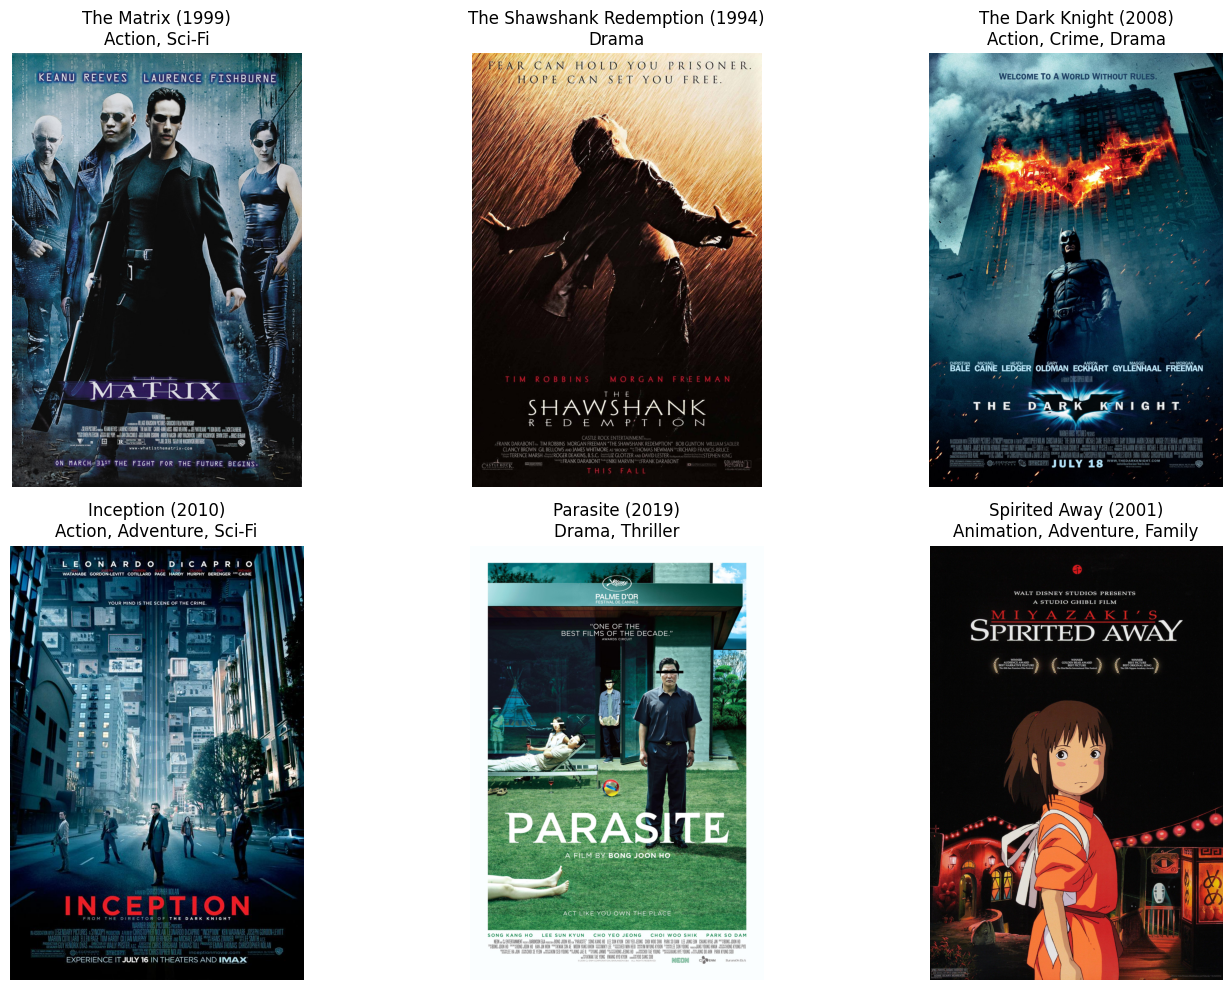

In [17]:
# 3. Tải và chuẩn bị hình ảnh mẫu cho phim
import requests
import os
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Tạo thư mục chứa hình ảnh nếu chưa tồn tại
image_dir = os.path.join(os.getcwd(), 'local_images')
os.makedirs(image_dir, exist_ok=True)

# Danh sách phim với poster (URL từ IMDB/Wikipedia)
movie_images = [
    {
        "title": "The Matrix",
        "url": "https://m.media-amazon.com/images/M/MV5BNzQzOTk3OTAtNDQ0Zi00ZTVkLWI0MTEtMDllZjNkYzNjNTc4L2ltYWdlXkEyXkFqcGdeQXVyNjU0OTQ0OTY@._V1_.jpg",
        "description": "Một hacker máy tính tìm hiểu về bản chất thực sự của thực tại.",
        "year": 1999,
        "genres": ["Action", "Sci-Fi"],
        "rating": 8.7
    },
    {
        "title": "The Shawshank Redemption",
        "url": "https://m.media-amazon.com/images/M/MV5BNDE3ODcxYzMtY2YzZC00NmNlLWJiNDMtZDViZWM2MzIxZDYwXkEyXkFqcGdeQXVyNjAwNDUxODI@._V1_.jpg",
        "description": "Hai người tù kết nối với nhau qua nhiều năm.",
        "year": 1994,
        "genres": ["Drama"],
        "rating": 9.3
    },
    {
        "title": "The Dark Knight",
        "url": "https://m.media-amazon.com/images/M/MV5BMTMxNTMwODM0NF5BMl5BanBnXkFtZTcwODAyMTk2Mw@@._V1_.jpg",
        "description": "Batman chiến đấu với kẻ thù nguy hiểm Joker.",
        "year": 2008,
        "genres": ["Action", "Crime", "Drama"],
        "rating": 9.0
    },
    {
        "title": "Inception",
        "url": "https://m.media-amazon.com/images/M/MV5BMjAxMzY3NjcxNF5BMl5BanBnXkFtZTcwNTI5OTM0Mw@@._V1_.jpg",
        "description": "Một tên trộm đánh cắp bí mật công ty thông qua công nghệ chia sẻ giấc mơ.",
        "year": 2010,
        "genres": ["Action", "Adventure", "Sci-Fi"],
        "rating": 8.8
    },
    {
        "title": "Parasite",
        "url": "https://m.media-amazon.com/images/M/MV5BYWZjMjk3ZTItODQ2ZC00NTY5LWE0ZDYtZTI3MjcwN2Q5NTVkXkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_.jpg",
        "description": "Một gia đình nghèo thâm nhập vào cuộc sống của một gia đình giàu có.",
        "year": 2019,
        "genres": ["Drama", "Thriller"],
        "rating": 8.5
    },
    {
        "title": "Spirited Away",
        "url": "https://m.media-amazon.com/images/M/MV5BMjlmZmI5MDctNDE2YS00YWE0LWE5ZWItZDBhYWQ0NTcxNWRhXkEyXkFqcGdeQXVyMTMxODk2OTU@._V1_.jpg",
        "description": "Một cô bé bị mắc kẹt trong một thế giới phép thuật và phải tìm cách trở về.",
        "year": 2001,
        "genres": ["Animation", "Adventure", "Family"],
        "rating": 8.6
    }
]

# Tải và lưu hình ảnh
downloaded_images = []

print("Đang tải hình ảnh poster phim...")
for movie in tqdm(movie_images):
    try:
        # Lấy hình ảnh từ URL
        response = requests.get(movie["url"])
        image = Image.open(BytesIO(response.content))
        
        # Tạo tên file và lưu hình ảnh
        filename = os.path.join(image_dir, f"{movie['title'].replace(' ', '_').replace(':', '')}.jpg")
        image.save(filename)
        
        # Thêm đường dẫn hình ảnh vào dict phim
        movie["image_path"] = filename
        downloaded_images.append(movie)
        
    except Exception as e:
        print(f"Lỗi khi tải {movie['title']}: {e}")

print(f"Đã tải {len(downloaded_images)} hình ảnh poster phim vào {image_dir}")

# Hiển thị các hình ảnh đầu tiên
if len(downloaded_images) > 0:
    plt.figure(figsize=(15, 10))
    for i, movie in enumerate(downloaded_images[:6]):
        plt.subplot(2, 3, i+1)
        img = Image.open(movie["image_path"])
        plt.imshow(img)
        plt.title(f"{movie['title']} ({movie['year']})\n{', '.join(movie['genres'])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# 4. Kết nối với Weaviate và sử dụng module CLIP
import weaviate
from weaviate import Client
from weaviate.classes.config import Configure, Property, VectorDistances, Multi2VecField
from weaviate.classes.config import DataType as WeaviateDataType
from weaviate.classes.query import Filter

# Thông số kết nối Weaviate
WEAVIATE_URL = "http://localhost:8080"

# Kết nối đến Weaviate
try:
    client = weaviate.connect_to_local()
    print(f"Đã kết nối thành công đến Weaviate tại {WEAVIATE_URL}")
    
    # Kiểm tra xem module CLIP có được kích hoạt không
    meta_info = client.get_meta()
    modules = meta_info.get('modules', {})
    
    if 'multi2vec-clip' in modules:
        print("Module CLIP đã được kích hoạt trong Weaviate!")
    else:
        print("Lưu ý: Module CLIP chưa được kích hoạt trong Weaviate.")
        print("Demo này sẽ tiếp tục, nhưng để có kết quả tốt nhất, hãy kích hoạt module CLIP như hướng dẫn ở trên.")
        
except Exception as e:
    print(f"Lỗi kết nối đến Weaviate: {e}")
    print("Vui lòng đảm bảo dịch vụ Weaviate đã được khởi chạy.")
    print("Demo này sẽ tiếp tục với giả định Weaviate đã được kích hoạt.")

Đã kết nối thành công đến Weaviate tại http://localhost:8080
Module CLIP đã được kích hoạt trong Weaviate!


c:\Users\hokha\AppData\Local\Programs\Python\Python313\Lib\site-packages\weaviate\warnings.py:130: DeprecationWarning: Dep005: You are using weaviate-client version 4.4.2. The latest version is 4.14.4.
            Please consider upgrading to the latest version. See https://weaviate.io/developers/weaviate/client-libraries/python for details.
  warnings.warn(


In [27]:
# 5. Tạo schema Weaviate cho bộ sưu tập đa phương tiện
MULTIMODAL_CLASS_NAME = "MovieWithPoster"

# Kiểm tra xem class đã tồn tại chưa và xóa nếu có
try:
    if client.collections.exists(MULTIMODAL_CLASS_NAME):
        client.collections.delete(MULTIMODAL_CLASS_NAME)
        print(f"Đã xóa class Weaviate hiện có: {MULTIMODAL_CLASS_NAME}")
except Exception as e:
    print(f"Cảnh báo: {e}")

# Tạo schema với thuộc tính hình ảnh và cấu hình module CLIP
try:
    movie_multimodal_collection = client.collections.create(
        name=MULTIMODAL_CLASS_NAME,
        description="Bộ sưu tập phim với hình ảnh poster cho demo tìm kiếm đa phương tiện",
        vectorizer_config=Configure.Vectorizer.multi2vec_clip(
            # name="title_vector",
            image_fields=[
                Multi2VecField(name="image", weight=0.7),  # Trọng số cho hình ảnh
            ],
            text_fields=[
                Multi2VecField(name="title", weight=0.1),  # Trọng số cho tiêu đề
                Multi2VecField(name="description", weight=0.2),  # Trọng số cho mô tả
            ]
        ),  # Sử dụng module CLIP
        properties=[
            Property(name="title", data_type=WeaviateDataType.TEXT, description="Tiêu đề phim", 
                   skip_vectorization=False),  # Vectorize tiêu đề
            Property(name="description", data_type=WeaviateDataType.TEXT, description="Mô tả phim",
                   skip_vectorization=False),  # Vectorize mô tả
            Property(name="year", data_type=WeaviateDataType.INT, description="Năm phát hành",
                   skip_vectorization=True),  # Không vectorize năm
            Property(name="genres", data_type=WeaviateDataType.TEXT_ARRAY, description="Thể loại phim",
                   skip_vectorization=True),  # Không vectorize thể loại
            Property(name="rating", data_type=WeaviateDataType.NUMBER, description="Điểm đánh giá",
                   skip_vectorization=True),  # Không vectorize đánh giá
            Property(name="image", data_type=WeaviateDataType.BLOB, description="Hình ảnh poster phim",
                   skip_vectorization=False)  # Vectorize hình ảnh với CLIP
        ],
        # Cấu hình vectorizer và index
        vector_index_config=Configure.VectorIndex.hnsw(
            ef_construction=128,
            distance_metric=VectorDistances.COSINE
        ),
    )
    print(f"Đã tạo Weaviate class: {MULTIMODAL_CLASS_NAME} với module CLIP")
except Exception as e:
    print(f"Lỗi khi tạo Weaviate schema: {e}")
    print("Tiếp tục demo với giả định schema đã được tạo.")

Đã tạo Weaviate class: MovieWithPoster với module CLIP


In [30]:
# 6. Nhập dữ liệu phim với hình ảnh vào Weaviate
import base64

def import_movies_with_images(client, movies):
    """Nhập phim với hình ảnh poster vào Weaviate sử dụng module CLIP"""
    collection = client.collections.get(MULTIMODAL_CLASS_NAME)
    
    for movie in tqdm(movies):
        try:
            # Đọc dữ liệu hình ảnh
            with open(movie["image_path"], "rb") as f:
                image_data = f.read()
            image_b64 = base64.b64encode(image_data).decode('utf-8')
            # Thêm phim vào collection
            # Lưu ý: Với module CLIP, Weaviate sẽ tự động tạo vector từ hình ảnh và văn bản
            collection.data.insert(
                properties={
                    "title": movie["title"],
                    "description": movie["description"],
                    "year": movie["year"],
                    "genres": movie["genres"],
                    "rating": movie["rating"],
                    "image": image_b64
                }
            )
        except Exception as e:
            print(f"Lỗi khi nhập {movie['title']}: {e}")
    
    return len(movies)

# Nhập dữ liệu
print(f"Đang nhập {len(downloaded_images)} phim với poster vào Weaviate...")
try:
    num_imported = import_movies_with_images(client, downloaded_images)
    print(f"Đã nhập thành công {num_imported} phim với poster vào Weaviate")
except Exception as e:
    print(f"Lỗi trong quá trình nhập: {e}")

Đang nhập 6 phim với poster vào Weaviate...


  0%|          | 0/6 [00:00<?, ?it/s]

Đã nhập thành công 6 phim với poster vào Weaviate


In [47]:
# 7. Định nghĩa các hàm tìm kiếm đa phương tiện

def text_to_image_search(client, query_text, top_k=3, filter_expr=None):
    """Tìm kiếm hình ảnh dựa trên truy vấn văn bản"""
    collection = client.collections.get(MULTIMODAL_CLASS_NAME)
    
    # Sử dụng nearText trong Weaviate (yêu cầu module CLIP)
    if filter_expr:
        results = collection.query.near_text(
            query=query_text,
            limit=top_k,
            return_properties=["title", "description", "year", "genres", "rating", "image"],
            filters=filter_expr
        ).objects
    else:
        results = collection.query.near_text(
            query=query_text,
            limit=top_k,
            return_properties=["title", "description", "year", "genres", "rating", "image"]
        ).objects
    
    return results

def image_to_text_search(client, image_path, top_k=3, filter_expr=None):
    """Tìm kiếm nội dung văn bản dựa trên hình ảnh truy vấn"""
    collection = client.collections.get(MULTIMODAL_CLASS_NAME)
    
    # Đọc hình ảnh truy vấn
    with open(image_path, "rb") as f:
        img_bytes = f.read()
    img_b64 = base64.b64encode(img_bytes).decode('utf-8')

    near_image_obj = {
        "image": img_b64
    }

    # Sử dụng nearImage trong Weaviate (yêu cầu module CLIP)
    with open(image_path, "rb") as f:
        if filter_expr:
            results = collection.query.near_image(
                near_image=f,
                limit=top_k,
                return_properties=["title", "description", "year", "genres", "rating", "image"],
                filters=filter_expr
            ).objects
        else:
            results = collection.query.near_image(
                near_image=f,
                limit=top_k,
                return_properties=["title", "description", "year", "genres", "rating", "image"]
            ).objects
    
    return results

# Hàm hỗ trợ hiển thị kết quả tìm kiếm hình ảnh
def display_image_search_results(results, title="Kết quả tìm kiếm"):
    """Hiển thị kết quả tìm kiếm hình ảnh"""
    if not results:
        print("Không tìm thấy kết quả.")
        return
    
    plt.figure(figsize=(15, 10))
    for i, result in enumerate(results[:6]):
        plt.subplot(2, 3, i+1)
        
        # Lấy hình ảnh từ kết quả
        props = result.properties
        img_bytes = base64.b64decode(props["image"])
        img_data = BytesIO(img_bytes)
        img = Image.open(img_data)
        
        plt.imshow(img)
        plt.title(f"{props['title']} ({props['year']})\n{', '.join(props['genres'])}")
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

WEAVIATE MULTIMODAL SEARCH: Text-to-Image

Ví dụ 1: Tìm kiếm 'phim khoa học viễn tưởng với hiệu ứng đặc biệt'


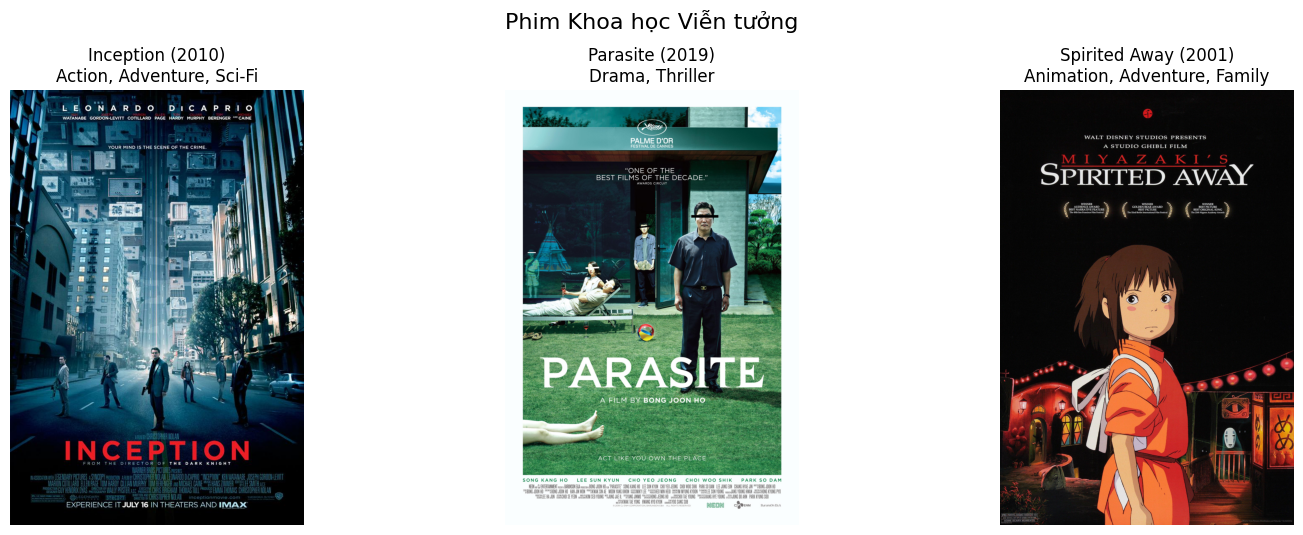


Ví dụ 2: Tìm kiếm 'phim siêu anh dùng'


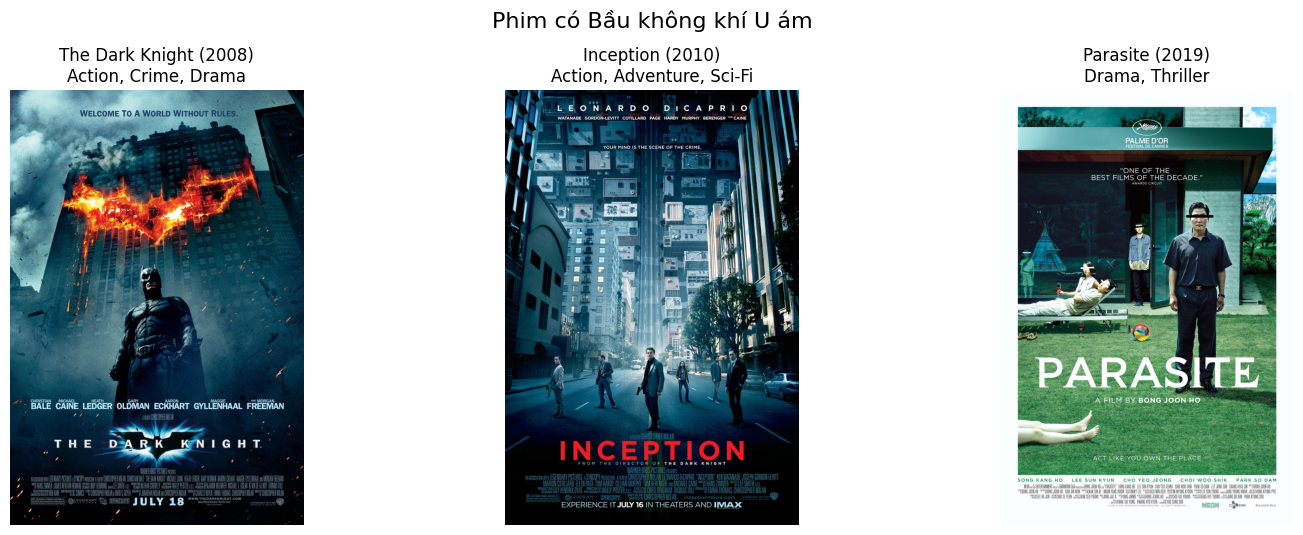


Ví dụ 3: Tìm kiếm 'phim hoạt hình Nhật Bản colorful'


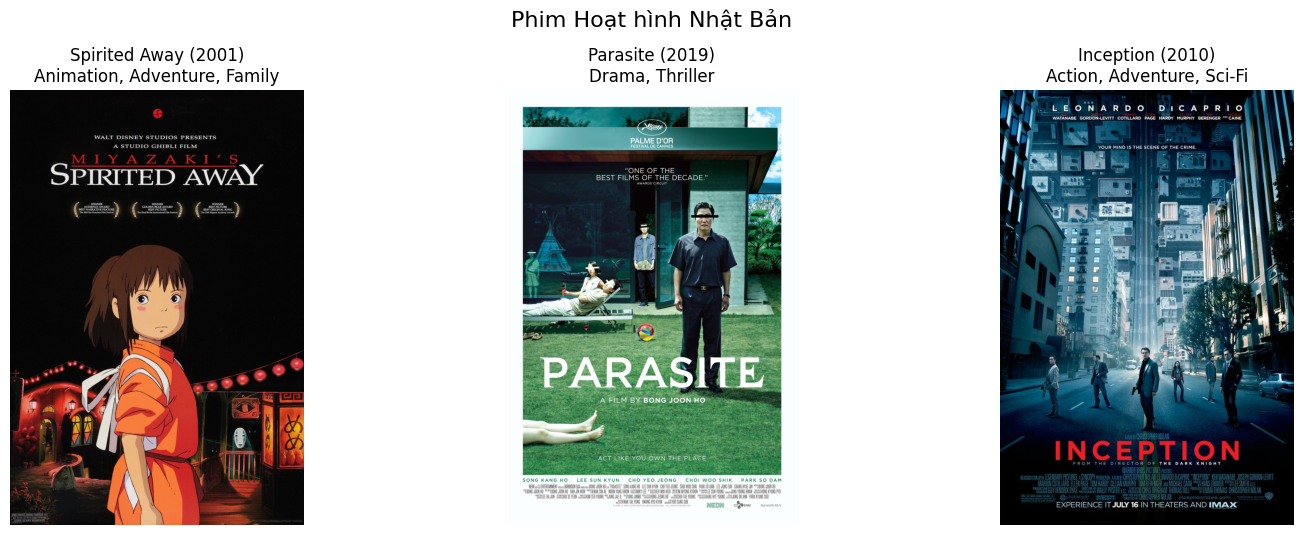

In [ ]:
# 8. Demo tìm kiếm hình ảnh từ văn bản (Text-to-Image)
print("WEAVIATE MULTIMODAL SEARCH: Text-to-Image")
print("=======================================\n")

# Ví dụ 1: Tìm kiếm phim khoa học viễn tưởng
print("Ví dụ 1: Tìm kiếm 'phim khoa học viễn tưởng với hiệu ứng đặc biệt'")
try:
    results = text_to_image_search(client, "phim khoa học viễn tưởng với hiệu ứng đặc biệt", top_k=3)
    display_image_search_results(results, "Phim Khoa học Viễn tưởng")
except Exception as e:
    print(f"Lỗi khi tìm kiếm: {e}")
    print("Đảm bảo Weaviate với module CLIP đã được khởi chạy.")

# Ví dụ 2: Tìm kiếm phim có bối cảnh đen tối
print("\nVí dụ 2: Tìm kiếm 'phim batman'")
try:
    results = text_to_image_search(client, "phim chiến đấu giữa batnam và joker", top_k=3)
    display_image_search_results(results, "Phim batman")
except Exception as e:
    print(f"Lỗi khi tìm kiếm: {e}")
    
# Ví dụ 3: Tìm kiếm phim hoạt hình
print("\nVí dụ 3: Tìm kiếm 'phim hoạt hình Nhật Bản colorful'")
try:
    results = text_to_image_search(client, "phim hoạt hình Nhật Bản colorful", top_k=3)
    display_image_search_results(results, "Phim Hoạt hình Nhật Bản")
except Exception as e:
    print(f"Lỗi khi tìm kiếm: {e}")

WEAVIATE MULTIMODAL SEARCH: Image-to-Image



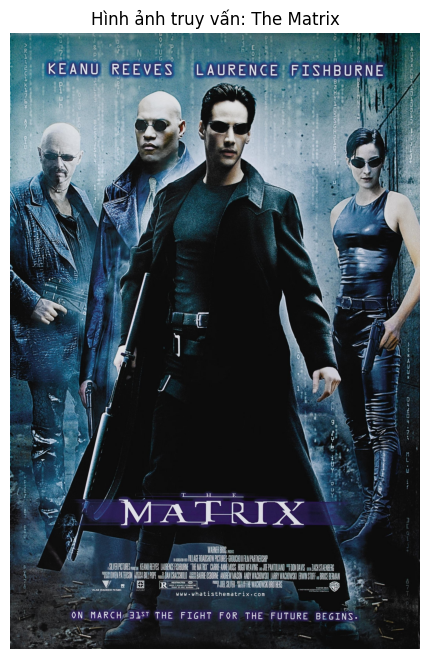

Đang tìm kiếm hình ảnh tương tự với: The Matrix


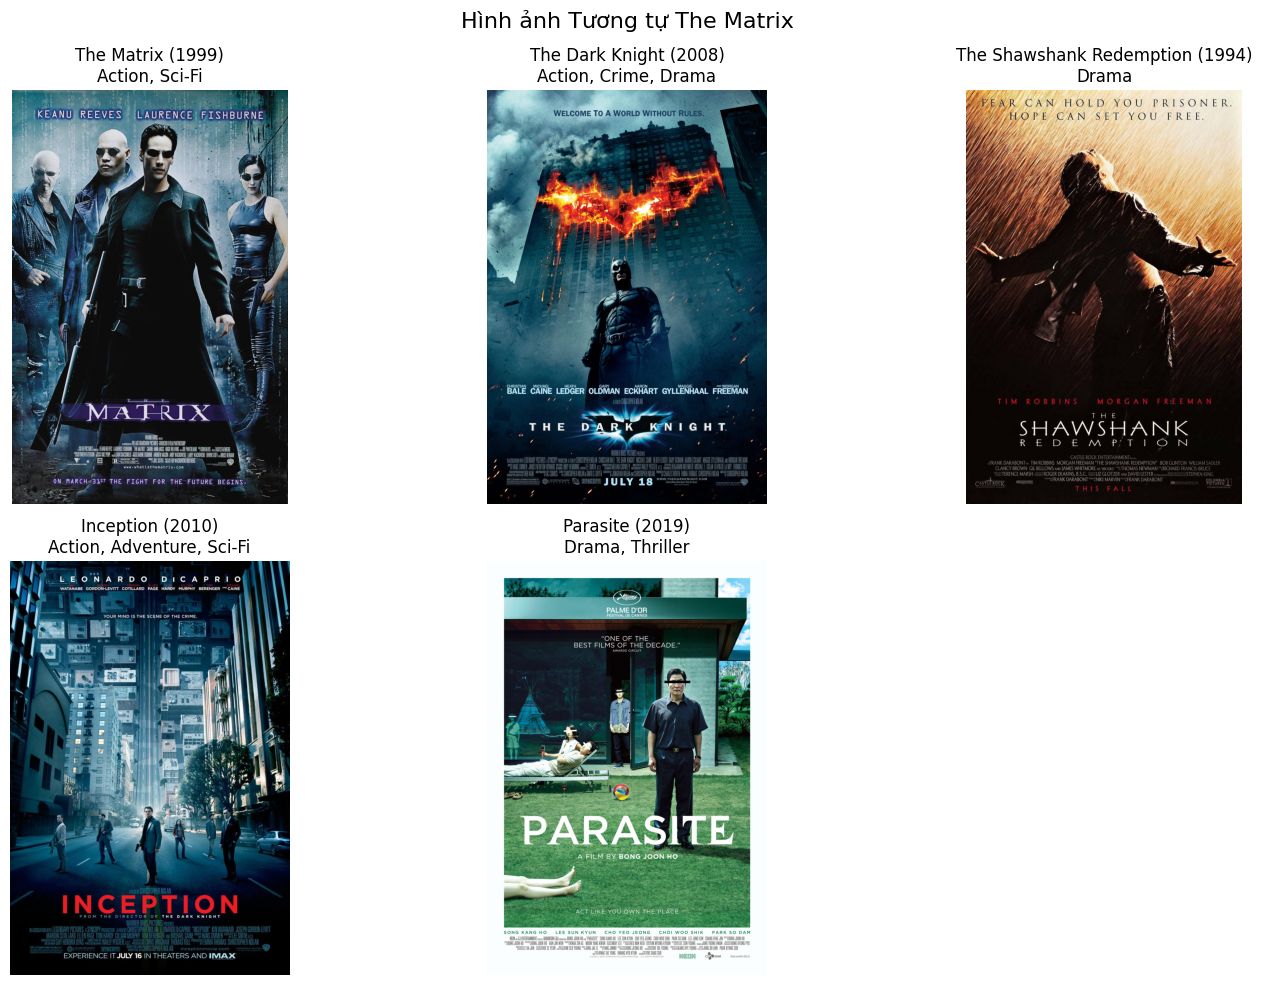

In [48]:
# 9. Demo tìm kiếm phim từ hình ảnh (Image-to-Image)
print("WEAVIATE MULTIMODAL SEARCH: Image-to-Image")
print("=========================================\n")

# Chọn một hình ảnh mẫu làm truy vấn
if len(downloaded_images) > 0:
    query_image_path = downloaded_images[0]["image_path"]
    query_image_title = downloaded_images[0]["title"]
    
    # Hiển thị hình ảnh truy vấn
    plt.figure(figsize=(6, 8))
    img = Image.open(query_image_path)
    plt.imshow(img)
    plt.title(f"Hình ảnh truy vấn: {query_image_title}")
    plt.axis('off')
    plt.show()
    
    # Tìm kiếm các hình ảnh tương tự
    print(f"Đang tìm kiếm hình ảnh tương tự với: {query_image_title}")
    try:
        results = image_to_text_search(client, query_image_path, top_k=5)
        # Hiển thị kết quả
        display_image_search_results(results, f"Hình ảnh Tương tự {query_image_title}")
    except Exception as e:
        print(f"Lỗi khi tìm kiếm: {e}")
        print("Đảm bảo Weaviate với module CLIP đã được khởi chạy.")
else:
    print("Không có hình ảnh khả dụng cho demo tìm kiếm.")

WEAVIATE TÌM KIẾM LAI (HYBRID SEARCH)

Ví dụ: Tìm kiếm phim với thể loại 'Sci-Fi' và năm phát hành sau 2000


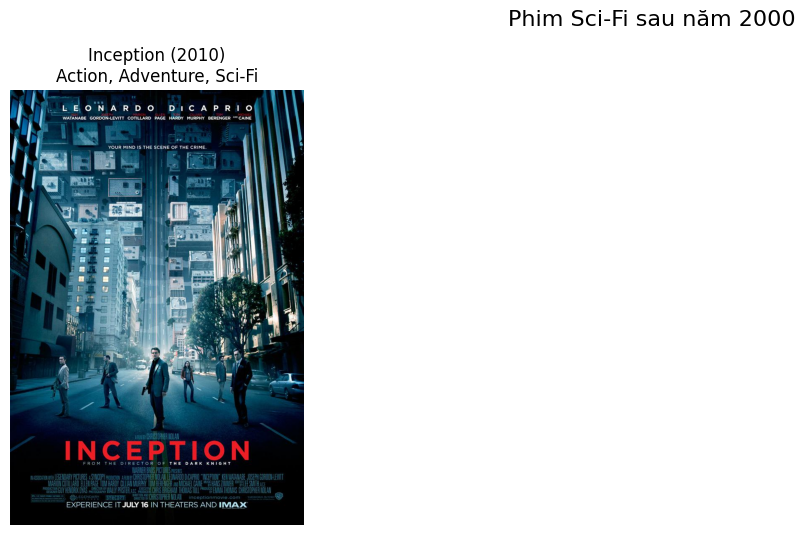

In [58]:
# 10. Tìm kiếm Lai (Hybrid Search) - Kết hợp tìm kiếm văn bản và hình ảnh
print("WEAVIATE TÌM KIẾM LAI (HYBRID SEARCH)")
print("=====================================\n")

# Demo tìm kiếm với bộ lọc
print("Ví dụ: Tìm kiếm phim với thể loại 'Sci-Fi' và năm phát hành sau 2000")

# Tạo bộ lọc cho thể loại Sci-Fi và năm > 2000
try:
    # Tạo bộ lọc phức tạp
    genre_filter = WeaviateFilter.by_property("genres").equal("Sci-Fi")
    year_filter = WeaviateFilter.by_property("year").greater_than(2000)
    combined_filter = (genre_filter & year_filter)
    
    # Tìm kiếm với bộ lọc
    results = text_to_image_search(
        client, 
        "phim khoa học viễn tưởng với công nghệ tiên tiến", 
        top_k=3,
        filter_expr=combined_filter
    )
    
    # Hiển thị kết quả
    display_image_search_results(results, "Phim Sci-Fi sau năm 2000")
except Exception as e:
    print(f"Lỗi khi tìm kiếm lai: {e}")
    print("Đảm bảo Weaviate với module CLIP đã được khởi chạy.")